# Lab I

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def step_ERK(F, R, a, b, c, tau, tn, un):
    # write a function that implements a general R stage explicit Runge-Kutta method to solve
    #
    # du/dt = F(t,u)
    # u(0) = u0
    #
    # input:
    #       tn - the current time (scalar)
    #       un - the current state (vector)
    #       F - the right-hand side function (returns vector, same dimension as un)
    #       u0 - the initial condition (vector, same dimension as un)
    #       tau - the timestep size (scalar)
    #       R - the number of stages (integer >= 1)
    #       a, b, c - the table of coefficients for the Runge-Kutta method, arranged as in the Butcher-Tableau
    #                 a is a matrix whose entries are accessed by a[r][s]
    #                 where 0 <= r <= R-1 and 0 <= s <= r-1
    #                 b and c are vectors whose entries are indexed from 0 to R-1
    #                 
    # output:
    #        tn1 - the next time (scalar)
    #        un1 - the next state (vector)
    
    tn1 = tn + tau
    un1 = un.copy()
    Krs = []
    for r in range(R):
        if r == 0:
            Kr = F(tn,un)
        else:
            tnr = tn + tau * c[r]
            unr = un.copy()
            for s in range(r):
                unr += tau * a[r][s] * Krs[s]
            Kr = F(tnr, unr)
        un1 += tau * b[r] * Kr
        Krs.append(Kr.copy())
    return tn1, un1

## Exercise II
### Part i

In [18]:
def compute_trajectory(g, mu, alpha, s0, x0, y0, tau):
    # write a function that computes the trajectory of the 
    # projectile with the given parameters and initial 
    # conditions using the forward Euler method
    #
    # inputs:
    #         g - gravity (m/s**2)
    #         mu - drag coefficient 
    #         alpha - launch angle (radians)
    #         s0 - initial speed (m/s)
    #         x0 - initial x position (m)
    #         y0 - initial y position (m)
    #         tau - timestep size (s)
    #
    # outputs:
    #         xs - vector of x positions
    #              xs[i] is the x position at time t_i = tau * i
    #         ys - vector of y positions
    #              ys[i] is the y position at time t_i = tau * i
    
    R = 1
    a = [[0]]
    b = [1]
    c = [0]
    
    vx0 = s0 * np.cos(alpha)
    vy0 = s0 * np.sin(alpha)
    
    u0 = np.array([x0, y0, vx0, vy0])
    
    def F(t, u):
        vx = u[2]
        vy = u[3]
        s = np.sqrt(vx**2 + vy**2)
        return np.array([vx, vy, -0.5 * mu * s * vx, -g - 0.5 * mu * s * vy])
    
    tn = 0
    un = u0.copy()
    
    xs = []
    ys = []
    
    while True:
        tn1, un1 = step_ERK(F=F, R=R, a=a, b=b, c=c, tau=tau, tn=tn, un=un)
        y = un1[1]
        if y < 0:
            break
        x = un1[0]
        xs.append(x)
        ys.append(y)
        tn = tn1
        un = un1.copy()
    
    return xs, ys

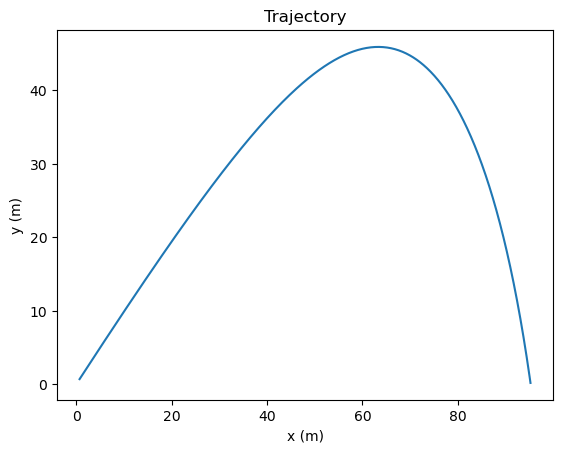

In [20]:
def test_trajectory():
    # test your algorithm by varying the parameters and initial conditions
    g = 9.80665
    mu = 0.04
    alpha = 45 / 180 * np.pi
    s0 = 100
    tau = 1/s0
    x0 = 0
    y0 = 0
    
    xs, ys = compute_trajectory(g=g, mu=mu, alpha=alpha, s0=s0, x0=x0, y0=y0, tau=tau)
    
    plt.plot(xs, ys)
    plt.title("Trajectory")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")

test_trajectory()

### Part 2

In [22]:
def compute_horizontal_distance(g, mu, alpha, s0, x0, y0, tau):
    # Write a function that computes the horizontal distance 
    # traveled by the projectile with the given parameters
    # and initial conditions
    #
    # inputs:
    #         g - gravity (m/s**2)
    #         mu - drag coefficient 
    #         alpha - launch angle (radians)
    #         s0 - initial speed (m/s)
    #         x0 - initial x position (m)
    #         y0 - initial y position (m)
    #         tau - timestep size (s)
    #
    # outputs:
    #         x - the horizontal distance traveled by the
    #             projectile
    
    xs, ys = compute_trajectory(g=g, mu=mu, alpha=alpha, s0=s0, x0=x0, y0=y0, tau=tau)
    return xs[-1]

In [24]:
# to find the maximum of a function f within an interval [a,b],
# we use the golden-section search algorithm
# https://en.wikipedia.org/wiki/Golden-section_search
def golden_section_search(f,a,b,tol=1e-6):
    golden_ratio = (np.sqrt(5) + 1) / 2
    
    while abs(b - a) > tol:
        c = b - (b - a) / golden_ratio
        d = a + (b - a) / golden_ratio
        if f(c) > f(d):
            b = d
        else:
            a = c

    return (b + a) / 2, f((b+a)/2)

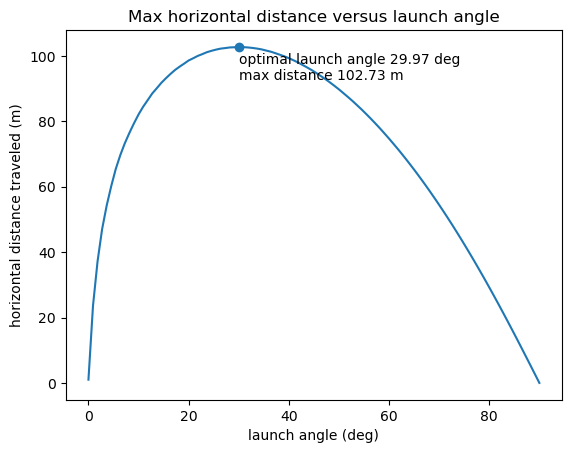

In [26]:
def test_optimal_angle():
    # test your algorithm by varying the parameters and initial conditions
    g = 9.81
    mu = 0.04
    s0 = 100
    x0 = 0
    y0 = 0
    tau = 1/s0

    alphas = []
    xs = []
    n = 100
    for i in range(n):
        alpha = np.pi/2/(n-1)*i
        x = compute_horizontal_distance(g=g,mu=mu,alpha=alpha,s0=s0,x0=x0,y0=y0,tau=tau)
        alphas.append(alpha/np.pi*180)
        xs.append(x)
    plt.plot(alphas,xs)

    f = lambda alpha : compute_horizontal_distance(g=g, mu=mu, alpha=alpha, s0=s0, x0=x0, y0=y0, tau=tau)
    optimal_angle, max_horizontal_distance = golden_section_search(f=f,a=0,b=np.pi/2)
    plt.scatter([optimal_angle/np.pi*180],[max_horizontal_distance])

    plt.annotate('optimal launch angle {:.2f} deg\nmax distance {:.2f} m'.format(optimal_angle/np.pi*180,max_horizontal_distance),(optimal_angle/np.pi*180,max_horizontal_distance), (optimal_angle/np.pi*180,max_horizontal_distance - 10))
    plt.xlabel('launch angle (deg)')
    plt.ylabel('horizontal distance traveled (m)')
    plt.title('Max horizontal distance versus launch angle')

test_optimal_angle()

## Exercise III

In [40]:
def solve_ERK(F, u0, T, N, R, a, b, c):
    # write a function that implements a general R stage explicit Runge-Kutta method to solve
    #
    # du/dt = F(t,u)
    # u(0) = u0
    #
    # on the interval [0,T] with N timesteps
    #
    # input:
    #       F - the right-hand side function (returns vector, same dimension as un)
    #       u0 - the initial condition (vector, same dimension as un)
    #       T - the final time
    #       N - the number of timesteps
    #       R - the number of stages (integer >= 1)
    #       a, b, c - the table of coefficients for the Runge-Kutta method, arranged as in the Butcher-Tableau
    #                 a is a matrix whose entries are accessed by a[r][s]
    #                 where 0 <= r <= R-1 and 0 <= s <= r-1
    #                 b and c are vectors whose entries are indexed from 0 to R-1
    #                 
    # output:
    #        ts - the vector of time values ts[i] = tau * i
    #        us - the matrix of states us[i,j] = jth component of state at time ts[i]
    
    tau = T / N
    ts = np.array([tau * i for i in range(N+1)])
    us = np.zeros((N+1,len(u0)))
    us[0,:] = u0.copy()
    un = u0.copy()
    tn = 0
    for i in range(1,N+1):
        tn1, un1 = step_ERK(F=F, tau=tau, R=R, a=a, b=b, c=c, tn=tn, un=un)
        us[i,:] = un1.copy()
        un = un1.copy()
        tn = tn1
    return ts, us

In [36]:
def compute_percent_relative_error(coarse_solution, fine_solution):
    # write a function to compute the errors between a coarse solution and a fine solution to 
    #
    # du/dt = F(t,u)
    # u(0) = u0
    #
    # where the fine solution is obtained by halving the timestep size of the coarse solution
    #
    # input:
    #       coarse_solution - the matrix of states coarse_solution[i][j] = jth component of the state at the ith coarse timestep
    #       fine_solution - the matrix of states fine_solution[i][j] = jth component of the state at the ith fine timestep
    #
    # output:
    #        errors - the vector errors[i] = percent relative error at the ith coarse timestep

    fine_solution_at_coarse_times = fine_solution[::2]
    errors = []
    for i in range(len(fine_solution_at_coarse_times)):
        percent_relative_error = np.linalg.norm(fine_solution_at_coarse_times[i]-coarse_solution[i])/np.linalg.norm(fine_solution_at_coarse_times[i])*100
        errors.append(percent_relative_error)
    return errors

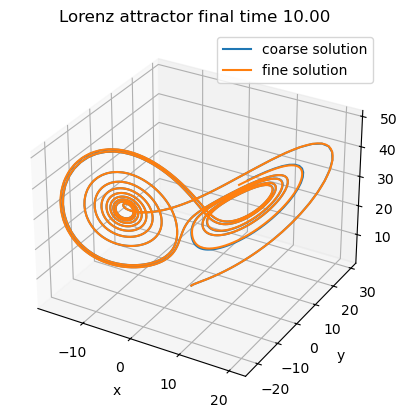

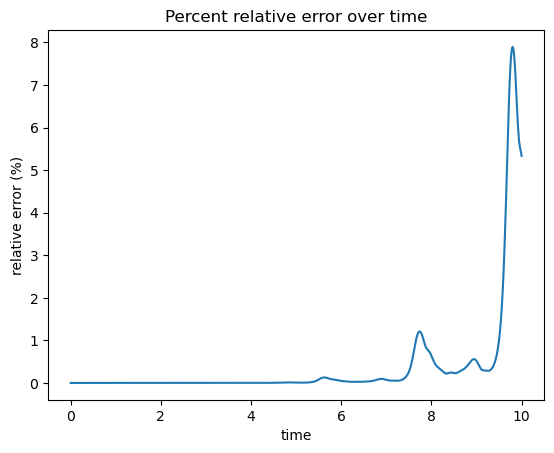

In [38]:
def test_Lorenz_attractor():
    # test your algorithm by changing the Butcher-Tableau and varying the parameters and initial conditions
    
    sigma = 10
    beta = 8 / 3
    rho = 28
    
    R = 4
    a = [[0],[1/2,0],[0,1/2,0],[0,0,1,0]]
    b = [1/6,2/6,2/6,1/6]
    c = [0,1/2,1/2,1]
    
    T = 10
    N = 100*T
    u0 = np.array([1.0,1.0,1.0])
    
    def F(t,u):
        return np.array([sigma * (u[1] - u[0]), u[0] * (rho - u[2]), u[0] * u[1] - beta * u[2]])
    
    coarse_ts, coarse_us = solve_ERK(F=F, u0=u0, T=T, N=N, R=R, a=a, b=b, c=c)
    fine_ts, fine_us = solve_ERK(F=F, u0=u0, T=T, N = 2 * N, R=R, a=a, b=b, c=c)
    
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot([state[0] for state in coarse_us],[state[1] for state in coarse_us], [state[2] for state in coarse_us], label='coarse solution')
    ax.plot([state[0] for state in fine_us],[state[1] for state in fine_us], [state[2] for state in fine_us], label='fine solution')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title("Lorenz attractor final time {:.2f}".format(fine_ts[-1]))
    plt.legend()

    errors = compute_percent_relative_error(coarse_us, fine_us)
    ax = plt.figure().add_subplot()
    plt.plot(coarse_ts, errors)
    plt.title("Percent relative error over time")
    plt.xlabel("time")
    plt.ylabel("relative error (%)")    


test_Lorenz_attractor()